<a href="https://colab.research.google.com/github/Amin-asadii/DeepLearning/blob/main/FRCNNcarDET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
pip install bcolz

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import os
import pandas as pd
from PIL import Image

import torch
print (torch.__version__)
import torchvision
import matplotlib.pyplot as plt

1.8.1+cu101


In [56]:
import torch
import torchvision
from torch import Tensor
import torch.nn as nn
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_ur
from typing import Type, Any, Callable, Union, List, Optional
from torchvision import transforms

import torch.nn as nn
import torchvision.models as models
import copy

In [30]:
print(torch.cuda.get_device_properties(0))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [31]:
root ='/content/drive/MyDrive/data'
phase = 'train'

imgs = os.listdir(os.path.join(root, 'training_images'))
#targets = pd.read_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv')
targets = pd.read_csv(os.path.join(root, '{}_solution_bounding_boxes (1).csv'.format(phase)))
idx=1000
img_path = os.path.join(root, 'training_images', imgs[idx] )
img = Image.open(img_path).convert('RGB')
#display
box_list = targets[targets['filename'] == imgs[idx]]
print(box_list[['xmin', 'ymin', 'xmax', 'ymax']].values.dtype)
print(box_list[['xmin', 'ymin', 'xmax', 'ymax']].values)


#display
box_list = targets[targets['filename'] == imgs[idx]]
print(box_list[['xmin', 'ymin', 'xmax', 'ymax']].values.dtype)
print(box_list[['xmin', 'ymin', 'xmax', 'ymax']].values)

from torchvision.transforms import functional as F

import torch.utils.data.dataloader
import torch.utils.data.dataset
import torch.utils.data

float64
[[331.1519537 192.4147362 429.959479  233.9848777]]
float64
[[331.1519537 192.4147362 429.959479  233.9848777]]


In [32]:
class cardataset (torch.utils.data.Dataset):
    def __init__(self, root, phase):
        self.root = root
        self.phase = phase

        #self.imgs = os.listdir(os.path.join(root, 'training_images'))
        #self.targets = pd.read_csv('/content/drive/MyDrive/data/train_solution_bounding_boxes (1).csv')
       
        self.targets = pd.read_csv(os.path.join(root, '{}_solution_bounding_boxes (1).csv'.format(phase)))
        self.imgs = self.targets['filename']

    def __getitem__(self, idx):

        img_path = os.path.join(self.root, 'training_images', self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        img = F.to_tensor(img)
        #tasvir target
        box_list = self.targets[self.targets['filename'] == self.imgs[idx]]
        box_list = box_list[['xmin', 'ymin', 'xmax', 'ymax']].values
        boxes = torch.tensor(box_list,  dtype=torch.float32)
        #
        labels = torch.ones((len(box_list), ), dtype=torch.int64)
        #
        target = {}
        target['boxes'] = boxes
        target ['labels'] = labels

        return img, target
    def __len__(self):
        return len(self.imgs)

In [33]:
train_dataset = cardataset('/content/drive/MyDrive/data', 'train')
test_dataset = cardataset('/content/drive/MyDrive/data', 'test')
#print (train_dataset.__getitem__(1000))
def new_concat(batch):
  return tuple(zip(*batch))


In [34]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6 , shuffle=True, collate_fn=new_concat)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1 , shuffle=True, collate_fn=new_concat)
#print (train_loader)
#print (next(iter(train_loader)))
#print (targets)
#imgs , targets = next (iter(train_loader))
print(test_loader)

In [35]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(1024 , 2)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [36]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=2,
                                               gamma=0.9)

In [37]:
import math
def train_one_epoch(model, optimizer, train_dataloader):
    model.train()
    total_loss = 0
    for images, targets in train_dataloader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    return total_loss/len(train_dataloader)

In [38]:
num_epochs = 1

for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader)
    print('epoch [{}]:  \t lr: {}  \t loss: {}  '.format(epoch, lr_scheduler.get_last_lr(), loss))
    lr_scheduler.step()

epoch [0]:  	 lr: [0.005]  	 loss: 0.22081495821475983  


In [43]:
! mkdir /content/output_images
! mkdir /content/crop_images

In [44]:
import matplotlib.patches as patches
import cv2
from google.colab.patches import cv2_imshow


def evaluate(model, test_dataloader):
    model.eval()
    with torch.no_grad():
        cnt = 0
        for images , targets in test_dataloader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            out = model(images)
            scores = out[0]['scores'].cpu().numpy()
            inds = scores > 0.7
            bxs = out[0]['boxes'].cpu().numpy()
            bxs = bxs[inds]
            gt = targets[0]['boxes'].cpu().numpy()
            # gt = gt[0]
            img = images[0].permute(1, 2, 0).cpu().numpy()
            #cv2_imshow(img.imag)
            
            #----------------------------------------------------------
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            for j in range(len(gt)):
                rect1 = patches.Rectangle((int(gt[j][0]),int(gt[j][1])),abs(gt[j][0]-gt[j][2]),
                                abs(gt[j][1]-gt[j][3]),linewidth=3,edgecolor='g',facecolor='none')
                ax.add_patch(rect1)
            for i in range(len(bxs)):
                rect = patches.Rectangle((int(bxs[i][0]),int(bxs[i][1])),abs(bxs[i][0]-bxs[i][2]),
                                         abs(bxs[i][1]-bxs[i][3]),linewidth=3,edgecolor='r',facecolor='none')
                print(len(bxs))
                
                ax.add_patch(rect)
                
                crop_img = img[int(bxs[i][1]):int(bxs[i][1]) + abs (int(bxs[i][1]) - int(bxs[i][3])), int(bxs[i][0]):int(bxs[i][0])+ abs (int (bxs[i][0] - bxs[i][2]))]
                #cv2.imwrite( i + ".jpg" ,crop_img )
                ax.imshow(crop_img)
                #ax.imshow(img)
                cv2.imwrite("iamge_"+str(i)+".jpg", crop_img)
                #print(crop_img)
                
                
                #cv2.imshow("crop", crop_img)
            fig.savefig("/content/output_images/{}.png".format(cnt), dpi=99, bbox_inches='tight')
            cnt = cnt + 1

1
1
1
1
1
1


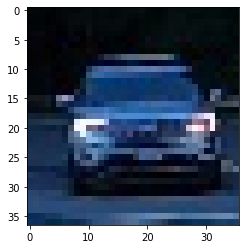

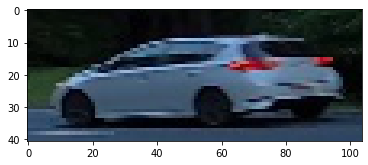

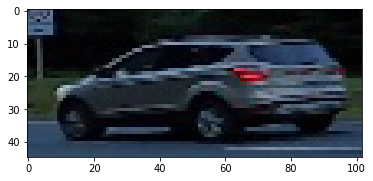

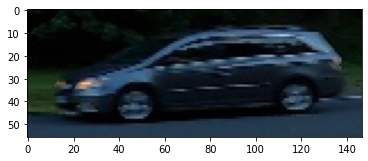

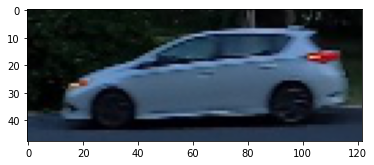

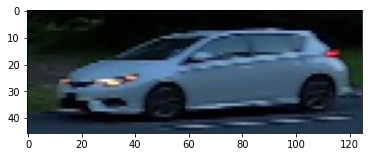

In [45]:
evaluate(model, test_loader)

## EVAL

In [46]:
batch_size = 1
num_classes = 21
lr = 0.001
num_epochs = 50
feature_extract = True

In [66]:
testset = torchvision.datasets.ImageFolder('/content/output_images',
                                                transform = transforms.Compose([transforms.Resize((160, 160)), transforms.ToTensor(),
                             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

RuntimeError: ignored

In [60]:
testloader  = torch.utils.data.DataLoader(dataset=testset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [61]:
classes = ('Acura Integra Type R 2001', 'Aston Martin V8 Vantage Convertible 2012', 
           
           'Audi 100 Sedan 1994', 'Bentley Arnage Sedan 2009', 'BMW 1 Series Convertible 2012',
           'Bugatti Veyron 16.4 Convertible 2009', 'Buick Enclave SUV 2012', 'Cadillac CTS-V Sedan 2012',
           'Chevrolet Avalanche Crew Cab 2012', 'Chrysler 300 SRT-8 2010',
           'Daewoo Nubira Wagon 2002', 'Dodge Caliber Wagon 2007', 'Eagle Talon Hatchback 1998',
           'Ferrari 458 Italia Convertible 2012', 'FIAT 500 Abarth 2012',
           'Fisker Karma Sedan 2012', 'Ford Edge SUV 2012', 'Geo Metro Convertible 1993', 'GMC Acadia SUV 2012', 'Honda Accord Coupe 2012',
           'HUMMER H2 SUT Crew Cab 2009')

In [62]:

    # Model CNN
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
convmodel = torchvision.models.mobilenet_v2()
convmodel.load_state_dict(copy.deepcopy(torch.load("model_state.pth",device)))




convmodel.to(device)

    # loss
loss_fn = nn.CrossEntropyLoss()
#

    # Optim
##optimizer_fn = torch.optim.SGD(convmodel.parameters(), lr=0.005,
                            ##momentum=0.9, weight_decay=0.0005)   
#torch.optim.Adam(convmodel.parameters(), lr=lr)
#lr_sch = torch.optim.lr_scheduler.StepLR(optimizer_fn, 5, gamma=0.5)
##lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_fn,
                                            ##   step_size=1,
                                              ## gamma=0.9)

#num_steps = len(trainloader)


In [63]:
    convmodel.eval()
    corrects = 0
    num_steps = len(testloader)
    for j, (imgs, lbls) in enumerate(testloader):
        #corrects = 00
    
        imgs = imgs.to(device)
        lbls = lbls.to(device)
        out = convmodel(imgs)
        predicted = torch.argmax(out, 1)
        corrects += torch.sum(predicted == lbls)
        print('Step [{}/{}] Acc {:.4f}: '.format(j+1, num_steps, 100.*corrects/((j+1)*batch_size)))

Step [1/868] Acc 0.0000: 
Step [2/868] Acc 0.0000: 
Step [3/868] Acc 0.0000: 
Step [4/868] Acc 0.0000: 
Step [5/868] Acc 0.0000: 
Step [6/868] Acc 0.0000: 
Step [7/868] Acc 0.0000: 
Step [8/868] Acc 0.0000: 
Step [9/868] Acc 0.0000: 
Step [10/868] Acc 0.0000: 
Step [11/868] Acc 0.0000: 
Step [12/868] Acc 0.0000: 
Step [13/868] Acc 0.0000: 
Step [14/868] Acc 0.0000: 
Step [15/868] Acc 0.0000: 
Step [16/868] Acc 0.0000: 
Step [17/868] Acc 0.0000: 
Step [18/868] Acc 0.0000: 
Step [19/868] Acc 0.0000: 
Step [20/868] Acc 0.0000: 
Step [21/868] Acc 0.0000: 
Step [22/868] Acc 0.0000: 
Step [23/868] Acc 0.0000: 
Step [24/868] Acc 0.0000: 
Step [25/868] Acc 0.0000: 
Step [26/868] Acc 0.0000: 
Step [27/868] Acc 0.0000: 
Step [28/868] Acc 0.0000: 
Step [29/868] Acc 0.0000: 
Step [30/868] Acc 0.0000: 
Step [31/868] Acc 0.0000: 
Step [32/868] Acc 0.0000: 
Step [33/868] Acc 0.0000: 
Step [34/868] Acc 0.0000: 
Step [35/868] Acc 0.0000: 
Step [36/868] Acc 0.0000: 
Step [37/868] Acc 0.0000: 
Step [38/8

KeyboardInterrupt: ignored